In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
import gdal
import os
import rasterio as rio
from rasterio.plot import show
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Importing data

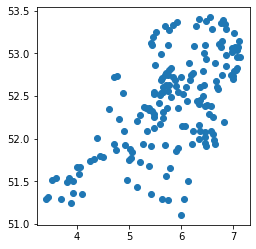

In [2]:
points_top_Soil = gpd.read_file('LUCAS_Topsoil_2015_20200323-shapefile/LUCAS_Topsoil_2015_20200323.shp')
NLD_boundaries = gpd.read_file('NLD_shapefile/gadm36_NLD_0.shp')

# Select by location based on the boundaries of the Netherlands
# Firstly, I checked if the two files have the same epsg
NLD_boundaries.crs == NLD_boundaries.crs
polygon_NLD = NLD_boundaries.geometry[0]
points_NLD = points_top_Soil[points_top_Soil.within(polygon_NLD)]
points_NLD.plot()
#os.makedirs("top_soil_NLD")
points_NLD.to_file('top_soil_NLD/top_soil_NLD.shp')

In [7]:
interpolated_clay = gdal.Grid('top_soil_NLD/interpolation_clay_sand_silt/interpolated_clay.tiff', 'top_soil_NLD/top_soil_NLD.shp', zfield='Clay', algorithm = 'linear:radius=0')
interpolated_sand = gdal.Grid('top_soil_NLD/interpolation_clay_sand_silt/interpolated_sand.tiff', 'top_soil_NLD/top_soil_NLD.shp', zfield='Sand', algorithm = 'linear:radius=0')
interpolated_silt = gdal.Grid('top_soil_NLD/interpolation_clay_sand_silt/interpolated_silt.tiff', 'top_soil_NLD/top_soil_NLD.shp', zfield='Silt', algorithm = 'linear:radius=0')

In [8]:
cwd = os.getcwd()
data_path = os.path.join(cwd, 'top_soil_NLD\interpolation_clay_sand_silt')

In [9]:
images = []
arrays_table= []

for i in os.listdir(data_path):
    path_file= os.path.join(data_path, i)
    file = rio.open(path_file)
    mask_file = file.read_masks(1)
    data_mask = np.ma.masked_array(file.read(1), mask_file==0)
    images.append(file)
    arrays_table.append(data_mask)

# Ploting soil content percentages

Text(-0.35, -0.1, 'Soil content')

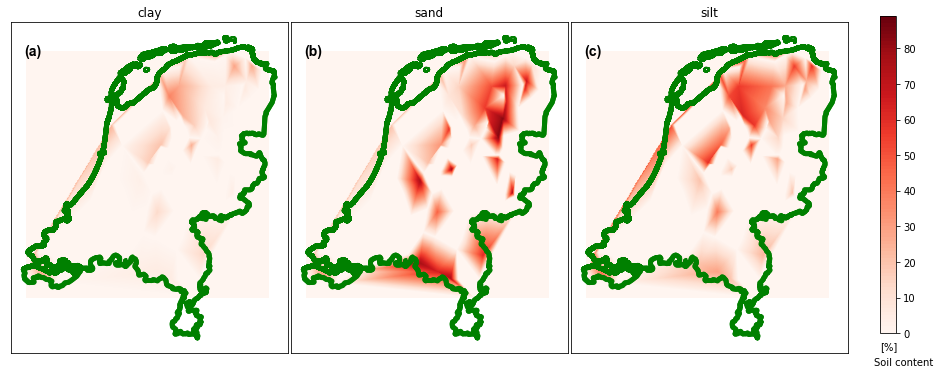

In [10]:
fig, axs = plt.subplots(1,3,figsize=(15,8))
labels_font = {'fontname':'Arial', 'size':'14', 'weight':'bold'}

fig.subplots_adjust(hspace = .15, wspace=.011)
soil_types = ['clay', 'sand', 'silt']
letters = ['a','b', 'c']
axs = axs.ravel()

for i in range(3):
    rio.plot.show(images[i], ax=axs[i],  cmap='Reds', vmin=0, vmax=90)
    NLD_boundaries.plot(ax=axs[i], facecolor='none', edgecolor='green', linewidth=5)
    axs[i].invert_yaxis()
    NLD_boundaries.plot(ax=axs[i], facecolor='none', edgecolor='green', linewidth=5)
    axs[i].set_yticklabels([])
    axs[i].set_xticklabels([])
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].set_title(soil_types[i])
    axs[i].text(0.05, 0.9, '('+str(letters[i])+')', **labels_font, transform=axs[i].transAxes)

# Plotling the colorbar
cbar_ax = fig.add_axes([0.93, 0.25, 0.015, 0.55])
sm = plt.cm.ScalarMappable(cmap='Reds')
colorbar = fig.colorbar(sm, cax=cbar_ax, ticks=range(0,1), boundaries=np.arange(0, 90), fraction=0.049)
colorbar.set_ticks(np.arange(0, 100, 10))
plt.text(0, -0.05, '[%]', transform=cbar_ax.transAxes)
plt.text(-0.35, -0.10, 'Soil content', transform=cbar_ax.transAxes)

# DEM

Digital Elevation Model (DEM) was derived from https://earthexplorer.usgs.gov/. More specifically, the Global Multi-resolution Terrain Elevation Data 2010 (GMTED2010) was used. The spatial resolution used was 30 arc second. Data is available at 7.5 arc second but coarse data was selected due to storage limitations. More information about the dataset can be found here https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-global-multi-resolution-terrain-elevation?qt-science_center_objects=0#qt-science_center_objects. In addition, clipping between NLD shapefile and DEM was conducted in QGIS. 


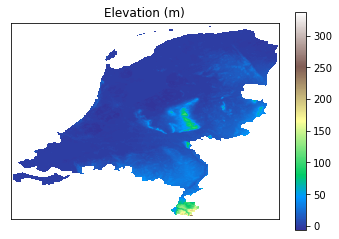

In [11]:
file = rio.open('DEM_clip_NLD/DEM_clip_NLD.tif')
mask_file = file.read_masks(1)
data_mask = np.ma.masked_array(file.read(1), mask_file==0)
plt.imshow(data_mask, cmap='terrain')
plt.colorbar()
plt.title('Elevation (m)');
plt.yticks([])
plt.xticks([]);

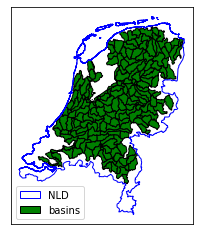

In [12]:
basins_NLD = gpd.read_file('Basins_NLD/basins_NLD_within.shp')
import matplotlib.patches as mpatches
LegendElement = [
                 mpatches.Patch(facecolor='None', edgecolor='blue', label='NLD'),
                 mpatches.Patch(facecolor='green', edgecolor='black', label='basins')]

fig, ax  = plt.subplots()
basins_NLD.plot(facecolor='green', edgecolor='black', ax=ax)
NLD_boundaries.plot(facecolor='None', edgecolor='blue', ax=ax)
ax.legend(handles = LegendElement, loc='lower left')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.set_yticks([])
ax.set_xticks([]);

# DEM zonal statistics

In [13]:
from rasterstats import zonal_stats
DEM_mean = zonal_stats("Basins_NLD/basins_NLD_within.shp", 'DEM_clip_NLD/DEM_clip_NLD.tif',
            stats="mean")
DEM_mean_list = [DEM_mean[i]['mean'] for i in range(len(DEM_mean))]
DEM_mean_df = pd.DataFrame(DEM_mean_list, columns=['DEM_mean'])

In [14]:
# DEM_mean_df

# Read the bands

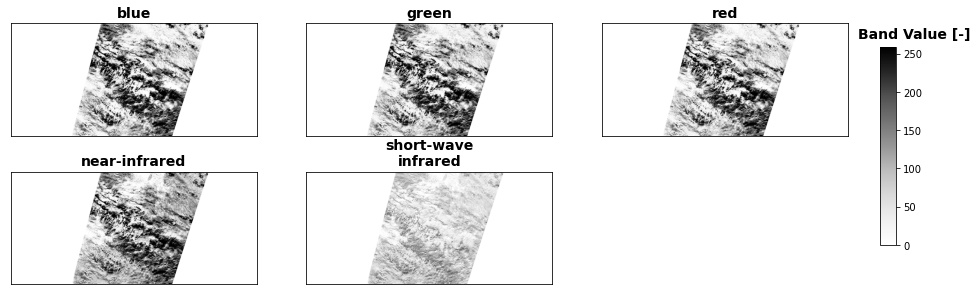

In [15]:
path_bands = 'Sentinel_bands'
band_names = ['blue','green','red', 'near-infrared', 'short-wave\ninfrared']
bands = {}
band_files = {}
fig, axs = plt.subplots(2,3,figsize=(15,5))
axs = axs.ravel()
# fig.subplots_adjust(hspace = .05, wspace=.01)

for j,i in enumerate(os.listdir(path_bands)[:-1]):
    path_file = os.path.join(path_bands, i)
    band = rio.open(path_file)
    band_files[band_names[j]]= band
    mask = band.read_masks(1)
    band_data = np.ma.masked_array(band.read(1), mask==0)
    bands[band_names[j]] = band_data
    ax=axs[j]
    ax.imshow(band_data, cmap='Greys')
    ax.set_title(band_names[j], fontweight='bold', fontsize=14)
    ax.set_yticks([])
    ax.set_xticks([])
    # Delete the last image
axs[5].remove()
    
cbar_ax = fig.add_axes([0.93, 0.25, 0.015, 0.55])
# Plotling the colorbar
sm = plt.cm.ScalarMappable(cmap='Greys')
colorbar = fig.colorbar(sm, cax=cbar_ax, ticks=range(0,1), boundaries=np.arange(0, 260), fraction=0.059)
colorbar.set_ticks(np.arange(0, 280, 50))
ax.text(2800,-680,'Band Value [-]', fontweight='bold', fontsize=14);

# Indices Estimation

## NDVI

NDVI (Normalized Difference Vegetation Index) is calculated from the visible and near-infrared light reflected by vegetation. Very low values of NDVI (0.1 and below) correspond to barren areas of rock, sand, or snow. Moderate values represent shrub and grassland (0.2 to 0.3), while high values indicate temperate and tropical rainforests (0.6 to 0.8). The formula is $$NDVI=\frac{NIR - Red}{NIR + Red}$$

where <br> NIR: NIR = pixel values from the near infrared band <br> Red: pixel values from red band,

The scematic below shows that ndvi can be used to evaluate the he4althiness of vegetation. High values correspond to vigorous and healthy plants and the otehr way around for negative values. 

<img src="Images/ndvi_image_V2.jpg" width='600'>

In [16]:
['blue','green','red', 'near-infrared', 'short-wave\ninfrared']

['blue', 'green', 'red', 'near-infrared', 'short-wave\ninfrared']

In [17]:
band_4_table = band_files['red'].read(1).astype('float')
band_8_table = band_files['near-infrared'].read(1).astype('float')
ndvi = np.where(band_8_table + band_4_table == 0,
                0,
                (band_8_table - band_4_table) / (band_8_table + band_4_table))

ndvi_image = rio.open('Sentinel_bands/Outputs_Images/ndvi_image.tiff', 'w', driver='Gtiff',
                     width = band_files['red'].width, height = band_files['red'].height,
                     count=1, crs = band_files['red'].crs,
                     transform = band_files['red'].transform, dtype='float64')
ndvi_image.write(ndvi,1)
ndvi_image.close()

C:\Users\ilias\AppData\Local\Temp/ipykernel_11748/2115375387.py:5: RuntimeWarning: invalid value encountered in true_divide
  (band_8_table - band_4_table) / (band_8_table + band_4_table))


## NDMI

"The Normalized Difference Moisture Index (NDMI) is sensitive to the moisture levels in vegetation. The formula is
$$NDMI=\frac{Green - Near Infrared}{Green + Near Infrared}$$

where <br> Green: pixel value from the green band, this is band 3 in Sentinel 2 <br> NIR: NIR = pixel values from the near infrared band, this is band 8 in Sentinel 2

In [19]:
band_3_table = band_files['green'].read(1).astype('float')
ndwi = np.where(band_3_table + band_8_table == 0,
                0,
                (band_3_table - band_8_table) / (band_3_table + band_8_table))

ndwi_image = rio.open('Sentinel_bands/Outputs_Images/ndwi_image.tiff', 'w', driver='Gtiff',
                     width = band_files['green'].width, height = band_files['green'].height,
                     count=1, crs = band_files['green'].crs,
                     transform = band_files['green'].transform, dtype='float64')
ndwi_image.write(ndwi,1)
ndwi_image.close()

C:\Users\ilias\AppData\Local\Temp/ipykernel_11748/2821259195.py:4: RuntimeWarning: invalid value encountered in true_divide
  (band_3_table - band_8_table) / (band_3_table + band_8_table))


# Bare Soil Index

Bare Soil Index (BSI) is a numerical indicator that combines blue, red, near infrared and short wave infrared spectral bands to capture soil variations. It is a normalized index where the short wave infrared and the red spectral bands are used to quantify the soil mineral composition, while the blue and the near infrared spectral bands are used to enhance the presence of vegetation. BSI formula is: <br> <br> $$BSI=\frac{(B11 + B04) - (B08+B02)}{(B11 + B04) + (B08+B02)}$$

where <br> B11: short wave infrared band in Sentinel 2 <br> B8: near infrared band in Sentinel 2 <br> B4: greenband in Sentinel 2 <br> B2: red band in Sentinel 2 

In [23]:
band_2_table = band_files['blue'].read(1).astype('float')
band_11_table = band_files['short-wave\ninfrared'].read(1).astype('float')
nom = (band_11_table + band_4_table) - (band_8_table + band_2_table)
denom = (band_11_table + band_4_table) + (band_8_table + band_2_table)
bsi = np.where(band_11_table + band_4_table + band_8_table + band_2_table == 0,
                0,
                nom/denom)

bsi_image = rio.open('Sentinel_bands/Outputs_Images/bsi_image.tiff', 'w', driver='Gtiff',
                     width = band_files['blue'].width, height = band_files['blue'].height,
                     count=1, crs = band_files['blue'].crs,
                     transform = band_files['blue'].transform, dtype='float64')
bsi_image.write(bsi,1)
bsi_image.close()

C:\Users\ilias\AppData\Local\Temp/ipykernel_11748/4033016928.py:7: RuntimeWarning: invalid value encountered in true_divide
  nom/denom)


# Ploting the indices

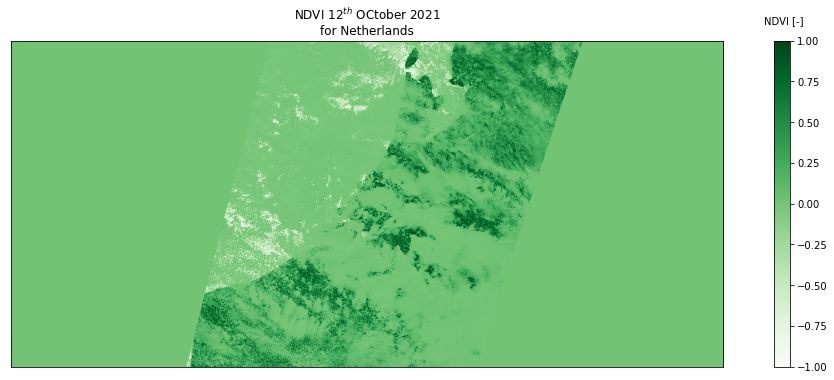

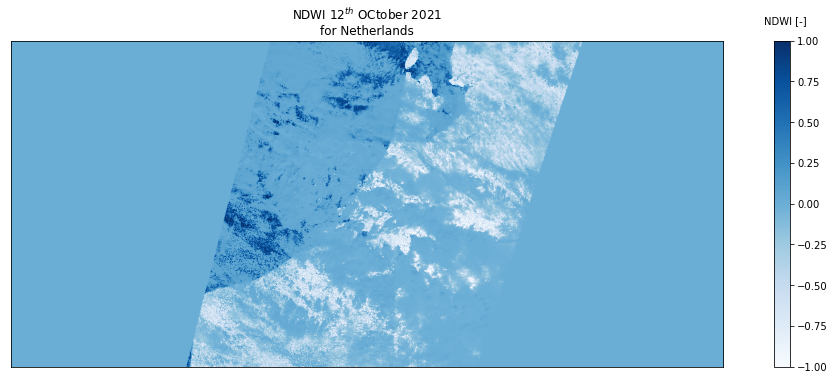

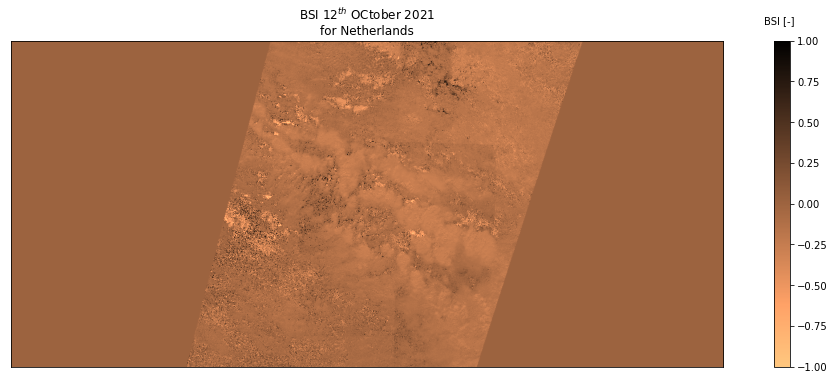

In [42]:
ndvi_image = rio.open('Sentinel_bands/Outputs_Images/ndvi_image.tiff')
ndwi_image = rio.open('Sentinel_bands/Outputs_Images/ndwi_image.tiff')
bsi_image = rio.open('Sentinel_bands/Outputs_Images/bsi_image.tiff')
indices_list = [ndvi_image, ndwi_image, bsi_image]
cmaps = ['Greens', 'Blues', 'copper_r']
titles = ['NDVI', 'NDWI', 'BSI']

def Exporting_img_data(image):
    mask = image.read_masks(1)
    data_without_mask = np.ma.masked_array(image.read(1), mask==0)
    return data_without_mask

for i in range(3):
    fig, ax = plt.subplots(figsize=(18,6))
    plt.imshow(Exporting_img_data(indices_list[i]), cmap=cmaps[i])
    plt.colorbar()
    plt.title(titles[i]+' $12^{th}$ OCtober 2021\nfor Netherlands')
    plt.yticks([])
    plt.xticks([]);
    plt.text(1320,-30, titles[i]+' [-]');

# Estimating zonal statistics

## Clipping the selected basins

One basin which is located on the east was not covered by the band-images downloaded  and removed.

<AxesSubplot:>

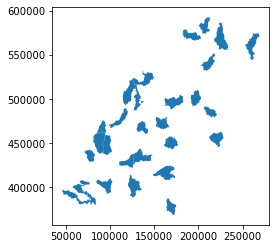

In [47]:
selected_basins = gpd.read_file('Basins_NLD/selected_basins/final_selected_basins_28992_fixed.shp')
selected_basins_update = selected_basins[selected_basins['HYBAS_ID'] != 2120368930]
selected_basins_update.plot()

In [48]:
selected_basins_update.to_file('Basins_NLD/selected_basins/final_selected_basins_28992_after_ndvi.shp')  
pd.options.mode.chained_assignment = None

In [ ]:
cols_to_be_deleted = set(selected_basins_update.columns) - set(['HYBAS_ID'])
selected_basins_update.drop(columns = cols_to_be_deleted, axis=1, inplace=True)

In [53]:
# selected_basins_update.crs
# The crs of "selected_basins_update" shapefile is 28992

## Applying zonal statistics


In [43]:
ndvi_image.crs

CRS.from_epsg(3857)

In [44]:
from osgeo import gdal

In [54]:
def Reprojecting_raster(file_path,output_path):
    filename = file_path
    input_raster = gdal.Open(filename)
    output_raster = output_path
    warp = gdal.Warp(output_raster,input_raster,dstSRS='EPSG:28992')
    warp = None # Closes the files
    
Reprojecting_raster('Sentinel_bands/Outputs_Images/ndvi_image.tiff', 'Sentinel_bands/Outputs_Images/ndvi_image_28992.tiff')

Reprojecting NDVI

In [55]:
# filename = 'Sentinel_bands/Outputs_Images/ndvi_image.tiff'
# input_raster = gdal.Open(filename)
# output_raster = 'Sentinel_bands/Outputs_Images/ndvi_image_28992.tiff'
# warp = gdal.Warp(output_raster,input_raster,dstSRS='EPSG:28992')
# warp = None # Closes the files

Clipping NDVI for the selected basins

# NDVI

In [65]:
NDVI_mean = zonal_stats('Basins_NLD/selected_basins/final_selected_basins_28992_after_ndvi.shp', 'Sentinel_bands/Outputs_Images/ndvi_image_28992.tiff',
            stats="mean", nodata=-999)
NDVI_mean_list = [NDVI_mean[i]['mean'] for i in range(len(NDVI_mean))]
NDVI_mean_df = pd.DataFrame(NDVI_mean_list, columns=['NDVI_mean'])
basins_NDVI = pd.merge(selected_basins_update, NDVI_mean_df, left_on=selected_basins_update.index, right_on=NDVI_mean_df.index, how='inner')
basins_NDVI.drop(columns=['key_0'], axis=1, inplace=True)

# basins_NDVI

In [60]:
basins_NDVI.dtypes

HYBAS_ID       int64
NDVI_mean    float64
dtype: object

# NDWI (Normalized Difference Water Index)

Reprojecting NDMI

In [ ]:
# filename = 'Sentinel_bands/Outputs_Images/ndwi_image.tiff'
# input_raster = gdal.Open(filename)
# output_raster = 'Sentinel_bands/Outputs_Images/ndwi_image_28992.tiff'
# warp = gdal.Warp(output_raster,input_raster,dstSRS='EPSG:28992')
# warp = None # Closes the files

In [ ]:
# The shapefile used for NDVI analysis is teh same as that one for NDMI 
NDWI_mean = zonal_stats('Basins_NLD/selected_basins/final_selected_basins_28992_after_NDVI.shp', 'Sentinel_bands/Outputs_Images/NDWI_image_28992.tiff',
            stats="mean", nodata=-999)
NDWI_mean_list = [NDWI_mean[i]['mean'] for i in range(len(NDWI_mean))]
NDWI_mean_df = pd.DataFrame(NDWI_mean_list, columns=['NDWI_mean'])
NDWI_mean_df

In [ ]:
basins_NDWI = pd.merge(selected_basins_update, NDWI_mean_df, left_on=selected_basins_update.index, right_on=NDWI_mean_df.index, how='inner')
basins_NDWI.drop(columns=['key_0'], axis=1, inplace=True)
basins_NDWI

# BSI

# k-means Analysis

k-means should be used for sample sizes above 500 - However, the analysis was performed for demonstration purposes and not to extract real insights of the data

Formann (1984) suggests the minimal sample size includes no less than 2^k cases (k = number of variables), preferably 5*(2^k).

https://www.researchgate.net/post/What-is-the-minimum-sample-size-to-conduct-a-cluster-analysis

In [ ]:
# https://www.knmi.nl/nederland-nu/klimatologie/daggegevens